In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import coolbox
from coolbox.api import *
import pyBigWig
import glob
import tqdm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import shap

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

import statsmodels
import random
import torch

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
from matplotlib import gridspec
from matplotlib.patches import Patch
set_all_seeds(42)

In [2]:
genes = pd.read_csv("./transcripts.bed",sep="\t",header=None)
genes.columns = ["chrom","start","end","name","strand"]
genes["start"] = genes["start"] // 5000 * 5000
genes["end"] = genes["end"] // 5000 * 5000 + 5000


In [3]:
variable_genes = pd.read_csv("./brain.top5k.variablegenes.tsv",header=None).values.T.astype(str)[0]
tss = pd.read_csv("./tss.bed",sep="\t",header=None)
tss.columns = ["chrom","start","end","gene","strand"]
tss["genome_coord"] =  tss.apply(lambda x: f"{x['chrom']}:{x['start']//5000*5000-int(2e6)}-{x['start']//5000*5000+5000+int(2e6)}", axis=1)
tss = tss.query('chrom != "chrM"')[["gene","genome_coord"]].drop_duplicates().reset_index(drop=True)
tss["tss_id"] = tss["gene"] + "_" + (tss.groupby("gene").cumcount() + 1).astype(str)

In [4]:
filepaths = glob.glob("./cor_res/*.tsv.gz")
tss_ids = [x.split("/")[-1].split(".")[0] for x in filepaths]

In [5]:
def _read_corres(filepath,tss_id):
    gene,genome_coord,tss_id = tss.query('tss_id == @tss_id')[["gene","genome_coord","tss_id"]].values[0]
    chrom,start_end = genome_coord.split(":")
    start,end = start_end.split("-")
    start,end = int(start),int(end)
    tss_bin = start + 2e6

    data = pd.read_csv(filepath,sep="\t")
    # if distance < 5, atac_neg10fdr > 2 & obsexp_distance_neg10fdr < -2 than significant
    data["distance_to_tss"] = np.arange(-2e6,2e6+5000,5000)
    data["chrom"] = chrom
    data["pos"] = start + data["distance_to_tss"] + 2e6
    data["pos"] = data["pos"].astype(int)
    data["tss_id"] = tss_id
    return data

In [6]:
dfs = []
for x,tss_id in tqdm.tqdm(zip(filepaths,tss_ids)):
    try:
        dfs.append(_read_corres(x,tss_id))
    except:
        pass

26it [00:00, 85.69it/s]

4860it [01:00, 80.33it/s] 


In [7]:
data = pd.concat(dfs)
data["gene"] = data["tss_id"].str.split("_").str[0] 

In [8]:
#data
print("Total tested pairs: ",data.shape[0])

Total tested pairs:  3822372


## Number of vargenes to considered

In [9]:
number_of_var_genes = [250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000]

In [10]:
number_of_triple_sig = []
for threshold in tqdm.tqdm(number_of_var_genes):
    temp_var_genes = variable_genes[:threshold]
    temp_all_cor = data.query('distance_highexp < 5 and gene in @temp_var_genes')
    temp_all_cor["obsexp_distance_fdr"] = statsmodels.stats.multitest.fdrcorrection(temp_all_cor["obsexp_distance_pval"])[1]
    temp_all_cor["atac_fdr"] = statsmodels.stats.multitest.fdrcorrection(temp_all_cor["atac_pval"])[1]
    temp_all_cor["ct_fdr"] = statsmodels.stats.multitest.fdrcorrection(temp_all_cor["ct_pval"])[1]
    temp_all_cor["distance_fdr"] = statsmodels.stats.multitest.fdrcorrection(temp_all_cor["distance_pval"])[1]

    number_of_triple_sig.append(temp_all_cor.query('obsexp_distance_fdr < 0.05 & obsexp_distance_corr < 0 & atac_fdr < 0.05 & ct_fdr < 0.05').shape[0])

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


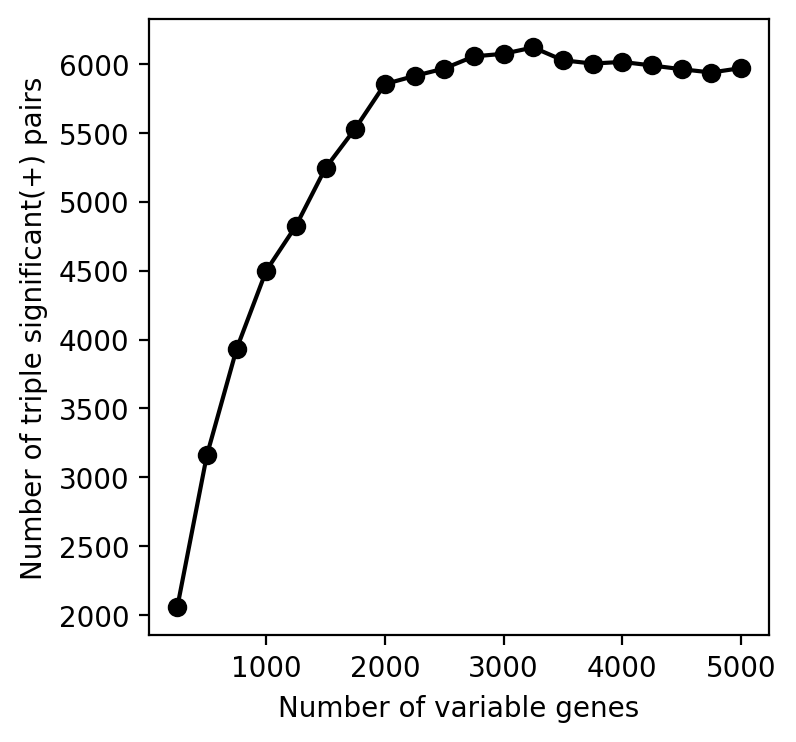

In [11]:
number_of_triple_sig

# line plot 
fig = plt.figure(figsize=(4,4))
plt.plot(number_of_var_genes,number_of_triple_sig,marker="o",color="black")

# y 

plt.xlabel("Number of variable genes")
plt.ylabel("Number of triple significant(+) pairs")
#plt.ylim(0,2800)

plt.show()


## Describe

In [12]:
pd.set_option('display.max_columns', None)

data = data.merge(genes[["name","start","end"]],left_on="gene",right_on="name",how="left")
data["within_gene"] = data.apply(lambda x: x["pos"] > (x["start"]+5000) and x["pos"] < (x["end"]-5000),axis=1) 

data_filter_distance = data.query('distance_highexp < 5 or within_gene').dropna()
print("Total tested pairs: ",data_filter_distance.shape[0])

Total tested pairs:  437776


In [13]:
## Filter gene within top 2000 variable genes
top2k_genes = variable_genes[:2000]
data_filter_distance = data_filter_distance.query('gene in @top2k_genes')
print("Total tested pairs: ",data_filter_distance.shape[0])

Total tested pairs:  195929


In [14]:
data_filter_distance["obsexp_distance_fdr"] = statsmodels.stats.multitest.fdrcorrection(data_filter_distance["obsexp_distance_pval"])[1]
data_filter_distance["atac_fdr"] = statsmodels.stats.multitest.fdrcorrection(data_filter_distance["atac_pval"])[1]
data_filter_distance["ct_fdr"] = statsmodels.stats.multitest.fdrcorrection(data_filter_distance["ct_pval"])[1]
data_filter_distance["distance_fdr"] = statsmodels.stats.multitest.fdrcorrection(data_filter_distance["distance_pval"])[1]

data_filter_distance["atac_neg10fdr"] = -np.log10(data_filter_distance["atac_fdr"])
data_filter_distance["obsexp_distance_neg10fdr"] = -np.log10(data_filter_distance["obsexp_distance_fdr"])
data_filter_distance["ct_neg10fdr"] = -np.log10(data_filter_distance["ct_fdr"])
data_filter_distance["distance_neg10fdr"] = -np.log10(data_filter_distance["distance_fdr"])


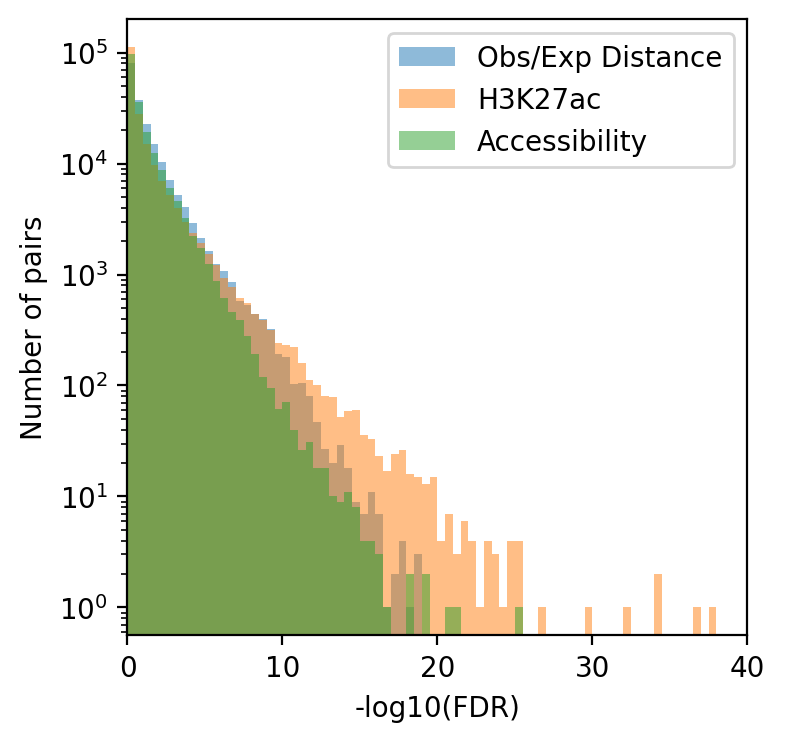

In [15]:
fig = plt.figure(figsize=(4,4))

plt.hist(data_filter_distance["obsexp_distance_neg10fdr"].values,label="Obs/Exp Distance",alpha=0.5,bins = np.arange(0,50,0.5))
plt.hist(data_filter_distance["ct_neg10fdr"].values,label="H3K27ac",alpha=0.5,bins = np.arange(0,50,0.5))
plt.hist(data_filter_distance["atac_neg10fdr"].values,label="Accessibility",alpha=0.5,bins = np.arange(0,50,0.5))

plt.yscale("log")
plt.legend()

plt.xlabel("-log10(FDR)")
plt.ylabel("Number of pairs")

plt.xlim(0,40)
plt.show()

In [16]:
data_filter_distance["ct_neg10fdr"] = data_filter_distance["ct_neg10fdr"].clip(lower=0)
data_filter_distance["atac_neg10fdr"] = data_filter_distance["atac_neg10fdr"].clip(lower=0)
data_filter_distance["obsexp_distance_neg10fdr"] = data_filter_distance["obsexp_distance_neg10fdr"].clip(lower=0)
data_filter_distance = data_filter_distance.reset_index(drop=True)

def safe_pow(base, exponent):
    """处理基数为0且指数为负数的情况,避免除以零错误"""
    return np.where((exponent == -1) & (base == 0), 0, np.power(base, exponent))
    
data_filter_distance["score"] = (safe_pow(data_filter_distance["ct_neg10fdr"]+1,np.sign(data_filter_distance["ct_corr"])) * safe_pow(data_filter_distance["atac_neg10fdr"]+1,np.sign(data_filter_distance["atac_corr"]))) * np.maximum(1,safe_pow(data_filter_distance["obsexp_distance_neg10fdr"]+1,-np.sign(data_filter_distance["obsexp_distance_corr"])))
# score = score / score.sum() in each tss_id
data_filter_distance["score"] = data_filter_distance["score"] / data_filter_distance.groupby("tss_id")["score"].transform("sum")

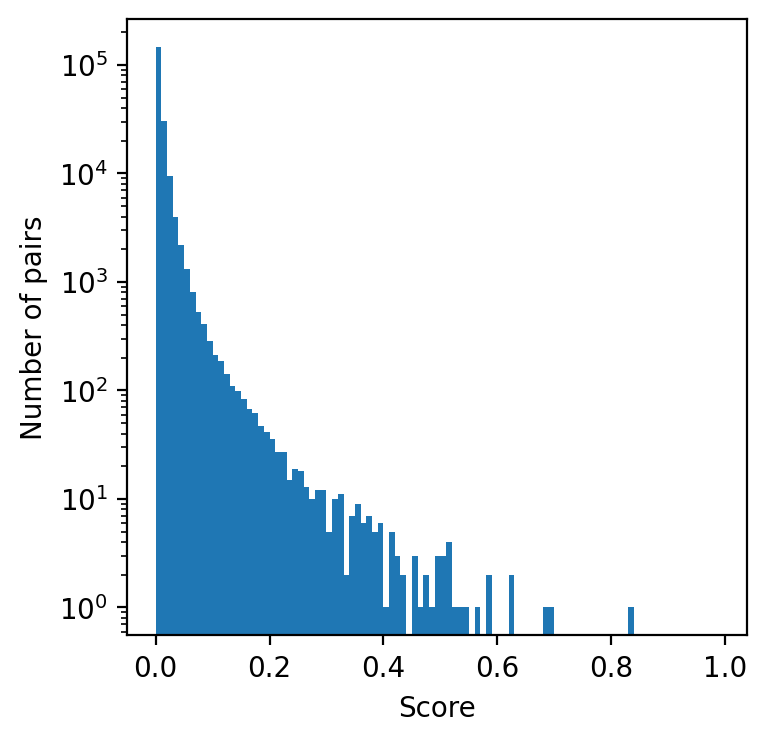

In [17]:
# distribution of score
fig = plt.figure(figsize=(4,4))
plt.hist(data_filter_distance["score"].values,bins = np.arange(0,1,0.01))
# log y
plt.yscale("log")
plt.xlabel("Score")
plt.ylabel("Number of pairs")
plt.show()

In [18]:
1/data_filter_distance.query('obsexp_distance_corr != 0')["obsexp_distance_corr"].values


array([-1.87582451, -1.91923726, -1.86927318, ..., -4.18518018,
       -4.66153555, -3.12493075])

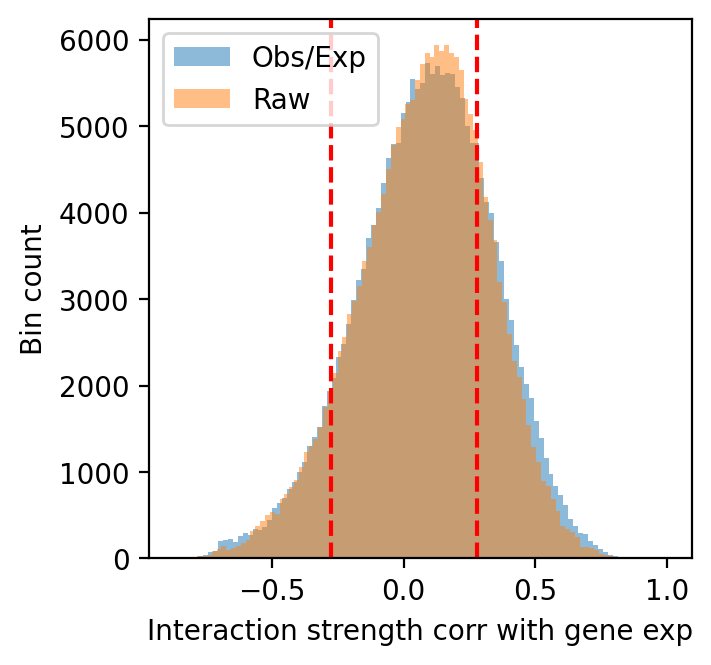

In [19]:
%config InlineBackend.figure_format = 'retina'

posmin_obsexp = data_filter_distance.query("obsexp_distance_fdr < 0.05 & obsexp_distance_corr > 0")["obsexp_distance_corr"].min()
negmin_obsexp = data_filter_distance.query("obsexp_distance_fdr < 0.05 & obsexp_distance_corr < 0")["obsexp_distance_corr"].max()

plt.figure(figsize=(3.5,3.5))
plt.hist(-(data_filter_distance.query('obsexp_distance_corr != 0')["obsexp_distance_corr"].values),bins=100,alpha=0.5,label="Obs/Exp")
plt.hist(-(data_filter_distance.query('distance_corr != 0')["distance_corr"].values),bins=100,alpha=0.5,label="Raw")

plt.axvline(-posmin_obsexp,color="red",linestyle="--")
plt.axvline(-negmin_obsexp,color="red",linestyle="--")
plt.xlabel("Interaction strength corr with gene exp")
plt.ylabel("Bin count")
#plt.xlim(-3,3)
plt.legend()
plt.show()

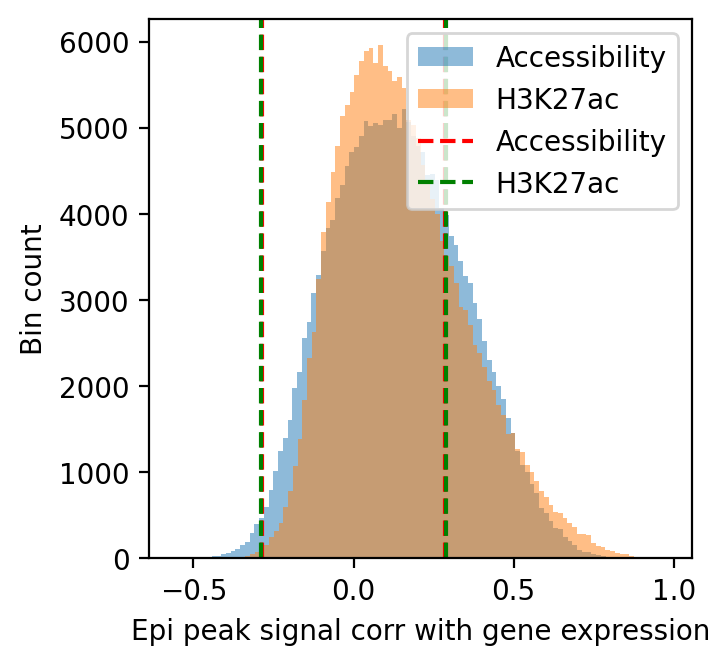

In [20]:
%config InlineBackend.figure_format = 'retina'

posmin_atac = data_filter_distance.query("atac_fdr < 0.05 & atac_corr > 0")["atac_corr"].min()
negmin_atac = data_filter_distance.query("atac_fdr < 0.05 & atac_corr < 0")["atac_corr"].max()
posmin_ct = data_filter_distance.query("ct_fdr < 0.05 & ct_corr > 0")["ct_corr"].min()
negmin_ct = data_filter_distance.query("ct_fdr < 0.05 & ct_corr < 0")["ct_corr"].max()

plt.figure(figsize=(3.5,3.5))
plt.hist(data_filter_distance.query('atac_corr != 0')["atac_corr"].values,bins=100,alpha=0.5,label="Accessibility")
plt.hist(data_filter_distance.query('ct_corr != 0')["ct_corr"].values,bins=100,alpha=0.5,label="H3K27ac")

plt.axvline(posmin_atac,color="red",linestyle="--",label="Accessibility")
plt.axvline(negmin_atac,color="red",linestyle="--")
plt.axvline(posmin_ct,color="green",linestyle="--",label="H3K27ac")
plt.axvline(negmin_ct,color="green",linestyle="--")

plt.xlabel("Epi peak signal corr with gene expression")
plt.ylabel("Bin count")
plt.legend()
plt.show()

In [21]:
plt.figure(figsize=(3.5,3.5))
plt.hist(-data_filter_distance.query('obsexp_distance_corr != 0')["obsexp_distance_corr"].values,bins=100,alpha=0.5,label="Obs/Exp",color="grey")
plt.axvline(0,color="black",linestyle="--",label="Obs/Exp pos min")
plt.savefig("figures/obs_exp_hist.pdf",bbox_inches="tight")
plt.close()

plt.figure(figsize=(3.5,3.5))
plt.hist(data_filter_distance.query('atac_corr != 0')["atac_corr"].values,bins=100,alpha=0.5,label="Raw",color="grey")
plt.axvline(0,color="black",linestyle="--",label="Raw pos min")
plt.savefig("figures/atac_hist.pdf",bbox_inches="tight")
plt.close()

plt.figure(figsize=(3.5,3.5))
plt.hist(data_filter_distance.query('ct_corr != 0')["ct_corr"].values,bins=100,alpha=0.5,label="Raw",color="grey")
plt.axvline(0,color="black",linestyle="--",label="Raw pos min")
plt.savefig("figures/ct_hist.pdf",bbox_inches="tight")
plt.close()



In [66]:
pdata_temp = data_filter_distance.query('obsexp_distance_corr != 0')[["obsexp_distance_corr","obsexp_distance_fdr"]]
pdata_temp["obsexp_distance_corr"] = -pdata_temp["obsexp_distance_corr"]
pdata_temp["type"] = "Not"
# fdr < 0.05 , corr > 0 to positive 
pdata_temp = pdata_temp.assign(type=lambda x: np.where((x["obsexp_distance_fdr"] < 0.05) & (x["obsexp_distance_corr"] > 0), "Positive", x["type"]))
pdata_temp = pdata_temp.assign(type=lambda x: np.where((x["obsexp_distance_fdr"] < 0.05) & (x["obsexp_distance_corr"] < 0), "Negative", x["type"]))

fig = plt.figure(figsize=(3.5,3.5))
sns.histplot(data=pdata_temp,x="obsexp_distance_corr",hue="type",bins=20,alpha=0.5,stat="count",palette={"Positive":"#b2182b","Negative":"#2166ac","Not":"#c9c9c9"})
plt.axvline(0,color="black",linestyle="--")

# save
plt.savefig("figures/obs_exp_hist.pdf",bbox_inches="tight")
plt.close()

pdata_temp = data_filter_distance.query('atac_corr != 0')[["atac_corr","atac_fdr"]]

pdata_temp["type"] = "Not"
# fdr < 0.05 , corr > 0 to positive
pdata_temp = pdata_temp.assign(type=lambda x: np.where((x["atac_fdr"] < 0.05) & (x["atac_corr"] > 0), "Positive", x["type"]))
pdata_temp = pdata_temp.assign(type=lambda x: np.where((x["atac_fdr"] < 0.05) & (x["atac_corr"] < 0), "Negative", x["type"]))
fig = plt.figure(figsize=(3.5,3.5))
sns.histplot(data=pdata_temp,x="atac_corr",hue="type",bins=20,alpha=0.5,stat="count",palette={"Positive":"#b2182b","Negative":"#2166ac","Not":"#c9c9c9"})
plt.axvline(0,color="black",linestyle="--")
# save
plt.savefig("figures/atac_hist.pdf",bbox_inches="tight")
plt.close()

pdata_temp = data_filter_distance.query('ct_corr != 0')[["ct_corr","ct_fdr"]]
pdata_temp["type"] = "Not"
# fdr < 0.05 , corr > 0 to positive
pdata_temp = pdata_temp.assign(type=lambda x: np.where((x["ct_fdr"] < 0.05) & (x["ct_corr"] > 0), "Positive", x["type"]))
pdata_temp = pdata_temp.assign(type=lambda x: np.where((x["ct_fdr"] < 0.05) & (x["ct_corr"] < 0), "Negative", x["type"]))
fig = plt.figure(figsize=(3.5,3.5))
sns.histplot(data=pdata_temp,x="ct_corr",hue="type",bins=20,alpha=0.5,stat="count",palette={"Positive":"#b2182b","Negative":"#2166ac","Not":"#c9c9c9"})
plt.axvline(0,color="black",linestyle="--")
# save
plt.savefig("figures/ct_hist.pdf",bbox_inches="tight")
plt.close()


In [22]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

Text(0.5, 0, 'Within gene')

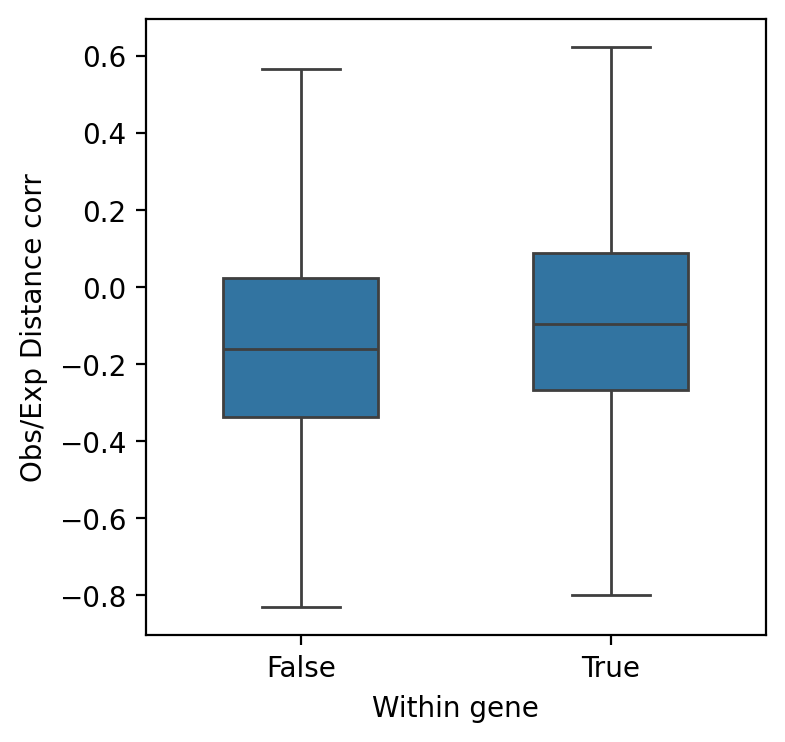

In [ ]:
temp_data = data_filter_distance.query('atac_corr > 0 or ct_corr > 0').query('atac_fdr < 0.05 or ct_fdr < 0.05').copy()
# groupby within gene, boxplot of obsexp_distance_corr
fig = plt.figure(figsize=(4,4))
sns.boxplot(x="within_gene",y="obsexp_distance_corr",data=temp_data,showfliers=False,width=0.5)
plt.ylabel("Obs/Exp Distance corr")
plt.xlabel("Within gene")



In [ ]:
print("Total tested pairs: ",data.shape[0])
print("Tested pairs with distance < 5 or : ",data_filter_distance.shape[0])


Total tested pairs:  3822372
Tested pairs with distance < 5 or :  195929


In [ ]:
data_filter_distance.query("atac_fdr < 0.05 or ct_fdr < 0.05 or obsexp_distance_fdr < 0.05").groupby("gene").size().describe()

count    1912.000000
mean       56.696653
std        49.660438
min         1.000000
25%        24.000000
50%        42.000000
75%        73.000000
max       411.000000
dtype: float64

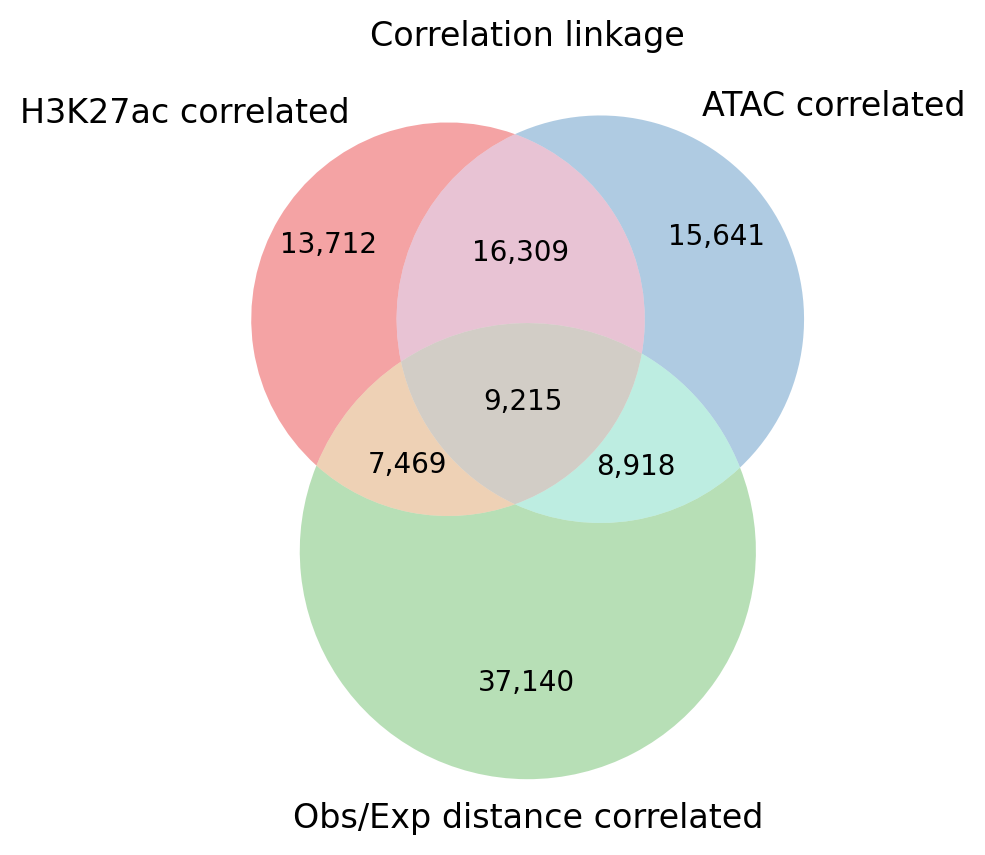

In [ ]:
atac_cor = data_filter_distance.query('atac_fdr < 0.05').shape[0]
ct_cor = data_filter_distance.query('ct_fdr < 0.05').shape[0]
obsexp_cor = data_filter_distance.query('obsexp_distance_fdr < 0.05').shape[0]

atac_ct_cor = data_filter_distance.query('atac_fdr < 0.05').query('ct_fdr < 0.05').shape[0]
atac_obsexp_cor = data_filter_distance.query('atac_fdr < 0.05').query('obsexp_distance_fdr < 0.05').shape[0]
ct_obsexp_cor = data_filter_distance.query('ct_fdr < 0.05').query('obsexp_distance_fdr < 0.05').shape[0]

all_cor = data_filter_distance.query('ct_fdr < 0.05 and atac_fdr < 0.05').query('obsexp_distance_fdr < 0.05').shape[0]

subsets = (
    ct_cor - atac_ct_cor - ct_obsexp_cor + all_cor,   # Only ct_neg10fdr > 2
    atac_cor - atac_ct_cor - atac_obsexp_cor + all_cor,   # Only atac_neg10fdr > 2
    atac_ct_cor - all_cor,    # ct & atac only
    obsexp_cor - atac_obsexp_cor - ct_obsexp_cor + all_cor,   # Only obsexp_distance_neg10fdr < -2
    ct_obsexp_cor - all_cor,    # ct & obsexp only
    atac_obsexp_cor - all_cor,    # atac & obsexp only
    all_cor     # All three
)

# Create the Venn diagram
plt.figure(figsize=(5, 5))
venn = venn3(subsets=subsets, 
             set_labels=('H3K27ac correlated', 'ATAC correlated', 'Obs/Exp distance correlated'),
              set_colors=['#e41a1c','#377eb8','#4daf4a'])

# Style the diagram
# venn.get_patch_by_id('100').set_color('#ffffff')  # Color for ct
# venn.get_patch_by_id('010').set_color('#b5d1de')  # Color for atac
# venn.get_patch_by_id('001').set_color('#d8d8d8')  # Color for obsexp

# venn.get_patch_by_id('110').set_color('#b5d1de')  # Color for ct & atac
# venn.get_patch_by_id('101').set_color('#d9e8ee')  # Color for ct & obsexp
# venn.get_patch_by_id('011').set_color('#ebeae9')  # Color for atac & obsexp

# venn.get_patch_by_id('111').set_color('#d9e2e7')  # Color for all three

plt.title("Correlation linkage")

# Add labels with counts
for region in ['100', '010', '110', '001', '101', '011', '111']:
    label = venn.get_label_by_id(region)
    label.set_text(f'{int(label.get_text()):,}')

# Display the plot
#plt.show()
# save 
plt.savefig("figures/venn_diagram.pdf", bbox_inches='tight', dpi=300)

In [ ]:
atac_cor

50083

In [ ]:
print(f"ATAC corr significant pairs: {atac_cor}, percentage: {atac_cor/data_filter_distance.shape[0]*100:.2f}%")
print(f"H3K27ac corr significant pairs: {ct_cor}, percentage: {ct_cor/data_filter_distance.shape[0]*100:.2f}%")
print(f"Obs/Exp distance corr significant pairs: {obsexp_cor}, percentage: {obsexp_cor/data_filter_distance.shape[0]*100:.2f}%")

print(f"ATAC & H3K27ac corr significant pairs: {atac_ct_cor}, percentage: {atac_ct_cor/data_filter_distance.shape[0]*100:.2f}%")
print(f"ATAC & & H3K27ac & Obs/Exp distance corr significant pairs: {all_cor}, percentage: {all_cor/data_filter_distance.shape[0]*100:.2f}%")

ATAC corr significant pairs: 50083, percentage: 25.56%
H3K27ac corr significant pairs: 46705, percentage: 23.84%
Obs/Exp distance corr significant pairs: 62742, percentage: 32.02%
ATAC & H3K27ac corr significant pairs: 25524, percentage: 13.03%
ATAC & & H3K27ac & Obs/Exp distance corr significant pairs: 9215, percentage: 4.70%


In [ ]:
# percent of positive corr
print(f"Percentage of positive ATAC corr: {data_filter_distance.query('atac_corr > 0 & atac_fdr < 0.05').shape[0] / atac_cor * 100:.2f}%")
print(f"Percentage of positive H3K27ac corr: {data_filter_distance.query('ct_corr > 0 & ct_fdr < 0.05').shape[0] / ct_cor * 100:.2f}%")
print(f"Percentage of positive Obs/Exp distance corr: {data_filter_distance.query('obsexp_distance_corr < 0 & obsexp_distance_fdr < 0.05').shape[0] / obsexp_cor * 100:.2f}%")

Percentage of positive ATAC corr: 96.54%
Percentage of positive H3K27ac corr: 99.46%
Percentage of positive Obs/Exp distance corr: 73.38%


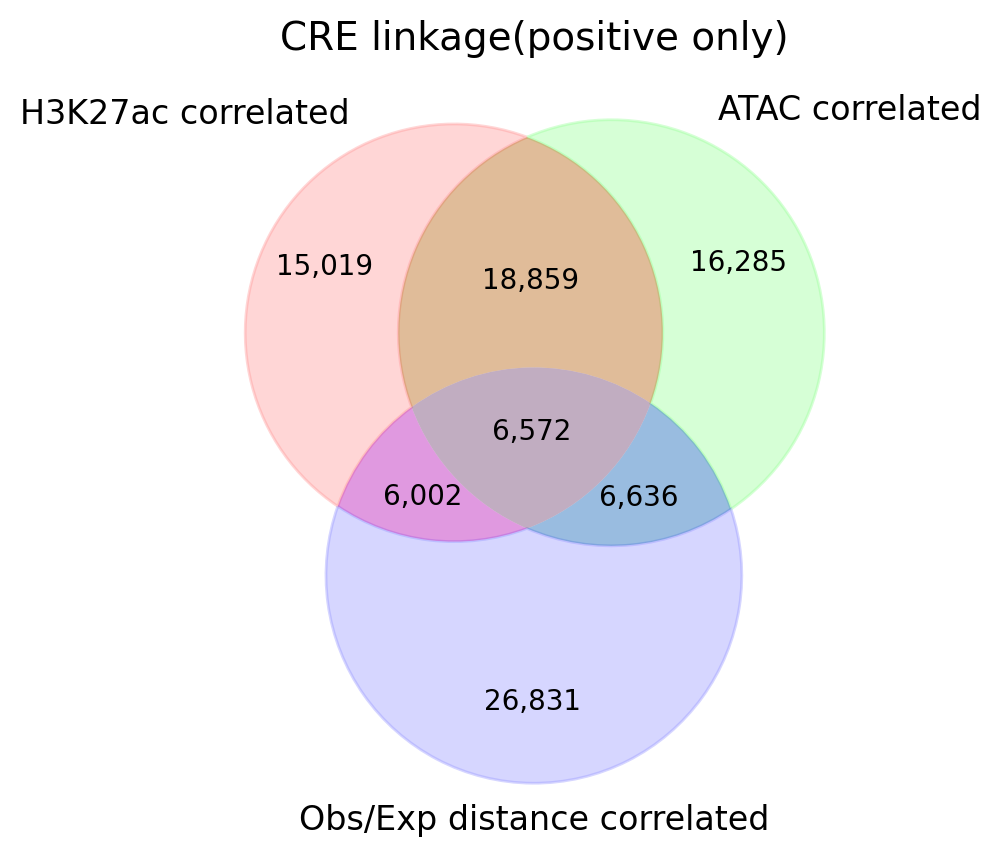

In [ ]:
atac_cor = data_filter_distance.query('atac_fdr < 0.05 & atac_corr > 0').shape[0]
ct_cor = data_filter_distance.query('ct_fdr < 0.05 & ct_corr > 0').shape[0]
obsexp_cor = data_filter_distance.query('obsexp_distance_fdr < 0.05 & obsexp_distance_corr < 0').shape[0]

atac_ct_cor = data_filter_distance.query('atac_fdr < 0.05 & atac_corr > 0').query('ct_fdr < 0.05 & ct_corr > 0').shape[0]
atac_obsexp_cor = data_filter_distance.query('atac_fdr < 0.05 & atac_corr > 0').query('obsexp_distance_fdr < 0.05 & obsexp_distance_corr < 0').shape[0]
ct_obsexp_cor = data_filter_distance.query('ct_fdr < 0.05 & ct_corr > 0').query('obsexp_distance_fdr < 0.05 & obsexp_distance_corr < 0').shape[0]

all_cor = data_filter_distance.query('ct_fdr < 0.05 & atac_fdr < 0.05 & ct_corr > 0 & atac_corr > 0').query('obsexp_distance_fdr < 0.05 & obsexp_distance_corr < 0').shape[0]

subsets = (
    ct_cor - atac_ct_cor - ct_obsexp_cor + all_cor,   # Only ct_neg10fdr > 2
    atac_cor - atac_ct_cor - atac_obsexp_cor + all_cor,   # Only atac_neg10fdr > 2
    atac_ct_cor - all_cor,    # ct & atac only
    obsexp_cor - atac_obsexp_cor - ct_obsexp_cor + all_cor,   # Only obsexp_distance_neg10fdr < -2
    ct_obsexp_cor - all_cor,    # ct & obsexp only
    atac_obsexp_cor - all_cor,    # atac & obsexp only
    all_cor     # All three
)
plt.figure(figsize=(5, 5))
venn = venn3(subsets=subsets, 
             set_labels=('H3K27ac correlated', 'ATAC correlated', 'Obs/Exp distance correlated'))

# Style the diagram
venn.get_patch_by_id('100').set_color('#FF9999')  # Color for ct
venn.get_patch_by_id('010').set_color('#99FF99')  # Color for atac
venn.get_patch_by_id('001').set_color('#9999FF')  # Color for obsexp
plt.title("CRE linkage(positive only)", fontsize=14)

# Add labels with counts
for region in ['100', '010', '110', '001', '101', '011', '111']:
    label = venn.get_label_by_id(region)
    label.set_text(f'{int(label.get_text()):,}')

# Display the plot
plt.show()

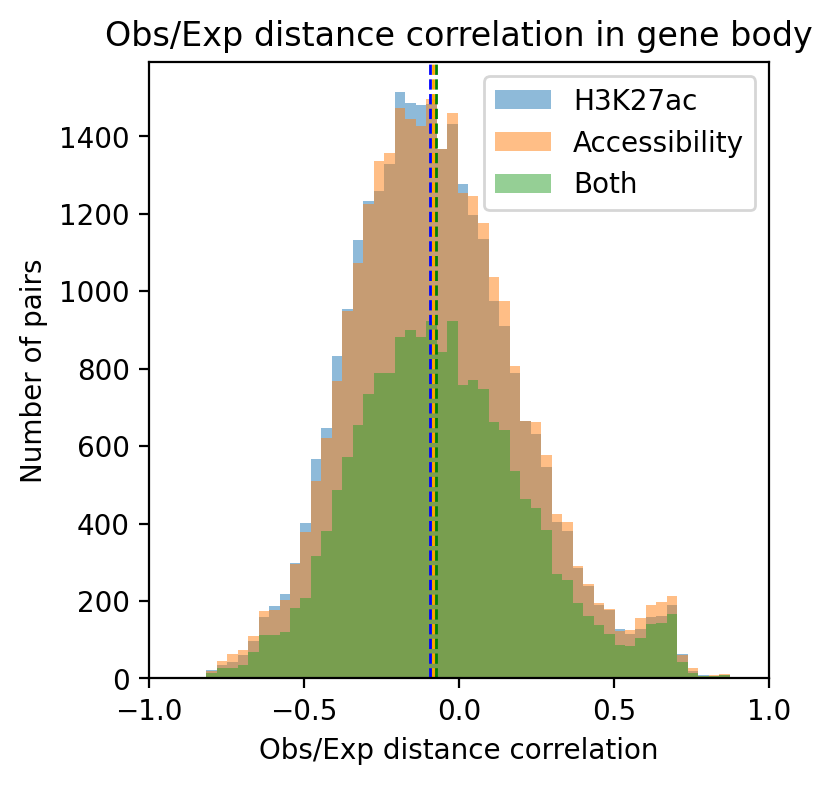

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.hist(data_filter_distance.query('within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & ct_corr > 0')["obsexp_distance_corr"].values,bins=50,alpha=0.5,label="H3K27ac")
plt.hist(data_filter_distance.query('within_gene & obsexp_distance_corr != 0 & atac_fdr < 0.05 & atac_corr > 0')["obsexp_distance_corr"].values,bins=50,alpha=0.5,label="Accessibility")
plt.hist(data_filter_distance.query('within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & atac_fdr < 0.05 & ct_corr > 0 & atac_corr > 0')["obsexp_distance_corr"].values,bins=50,alpha=0.5,label="Both")
# vertile line of mean
plt.axvline(data_filter_distance.query('within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & ct_corr > 0')["obsexp_distance_corr"].median(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(data_filter_distance.query('within_gene & obsexp_distance_corr != 0 & atac_fdr < 0.05 & atac_corr > 0')["obsexp_distance_corr"].median(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(data_filter_distance.query('within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & atac_fdr < 0.05 & ct_corr > 0 & atac_corr > 0')["obsexp_distance_corr"].median(), color='green', linestyle='dashed', linewidth=1)

plt.xlim(-1,1)

plt.ylabel("Number of pairs")
plt.xlabel("Obs/Exp distance correlation")
plt.title("Obs/Exp distance correlation in gene body")
plt.legend()
plt.show()

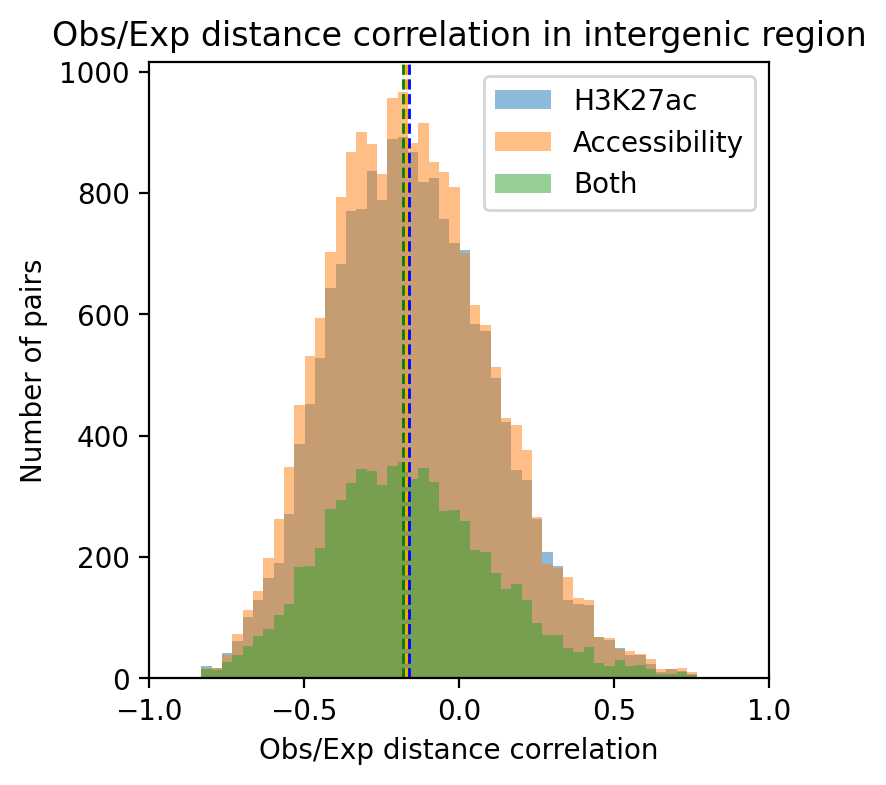

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.hist(data_filter_distance.query('not within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & ct_corr > 0')["obsexp_distance_corr"].values,bins=50,alpha=0.5,label="H3K27ac")
plt.hist(data_filter_distance.query('not within_gene & obsexp_distance_corr != 0 & atac_fdr < 0.05 & atac_corr > 0')["obsexp_distance_corr"].values,bins=50,alpha=0.5,label="Accessibility")
plt.hist(data_filter_distance.query('not within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & atac_fdr < 0.05 & ct_corr > 0 & atac_corr > 0')["obsexp_distance_corr"].values,bins=50,alpha=0.5,label="Both")
# vertile line of mean
plt.axvline(data_filter_distance.query('not within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & ct_corr > 0')["obsexp_distance_corr"].median(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(data_filter_distance.query('not within_gene & obsexp_distance_corr != 0 & atac_fdr < 0.05 & atac_corr > 0')["obsexp_distance_corr"].median(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(data_filter_distance.query('not within_gene & obsexp_distance_corr != 0 & ct_fdr < 0.05 & atac_fdr < 0.05 & ct_corr > 0 & atac_corr > 0')["obsexp_distance_corr"].median(), color='green', linestyle='dashed', linewidth=1)

plt.xlim(-1,1)

plt.ylabel("Number of pairs")
plt.xlabel("Obs/Exp distance correlation")
plt.title("Obs/Exp distance correlation in intergenic region")
plt.legend()
plt.show()

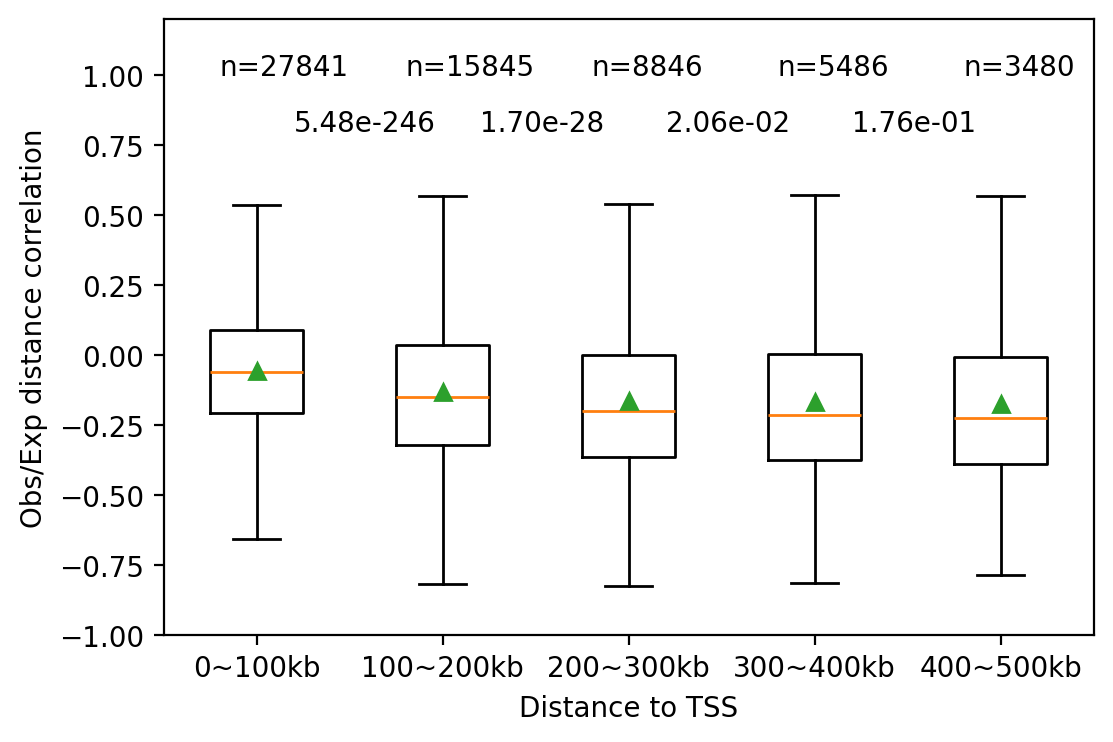

In [ ]:
# 定义 10 个区间
bins = np.arange(0, 6e5, 1e5)  # 0kb, 100kb, ..., 1mb
labels = [f"{int(b/1e3)}~{int(bins[i+1]/1e3)}kb" for i, b in enumerate(bins[:-1])]

# 按区间分组
data_groups = [
    data_filter_distance.query(
        '(ct_fdr < 0.05 & ct_corr > 0) or (atac_fdr < 0.05 & atac_corr > 0) & obsexp_distance_corr != 0'
    ).query(f'abs(distance_to_tss) >= {bins[i]} & abs(distance_to_tss) < {bins[i+1]}')["obsexp_distance_corr"].values
    for i in range(len(bins) - 1)
]

# 画图
fig, ax = plt.subplots(figsize=(6, 4))
plt.boxplot(data_groups, labels=labels, showfliers=False, widths=0.5, showmeans=True)

# 标注样本数
for i, data in enumerate(data_groups):
    plt.text(i + 0.8, 1, f"n={len(data)}", fontsize=10)

plt.xlabel("Distance to TSS")
plt.ylabel("Obs/Exp distance correlation")
plt.ylim(-1, 1.2)

# 计算统计检验（Mann-Whitney U）
p_values = [
    mannwhitneyu(data_groups[i], data_groups[i+1])[1]
    if len(data_groups[i]) > 0 and len(data_groups[i+1]) > 0 else np.nan
    for i in range(len(data_groups) - 1)
]

# 标注 p 值
for i, p in enumerate(p_values):
    if not np.isnan(p):
        plt.text(i + 1.2, 0.8, f"{p:.2e}", fontsize=10)

plt.show()


In [ ]:
max_distance = 1e6  # 1Mb
temp_data = data_filter_distance.query('(ct_fdr < 0.05 or atac_fdr < 0.05 or obsexp_distance_fdr < 0.05) & obsexp_distance_corr != 0 & abs(distance_to_tss) <= @max_distance')

temp_data['distance_bin'] = pd.cut(
    np.abs(temp_data['distance_to_tss']), 
    bins=np.arange(0, np.abs(temp_data['distance_to_tss']).max()+1e5, 1e5)
)

p_values = []

for bin_name, bin_data in temp_data.groupby('distance_bin'):
    within_gene = bin_data[bin_data['within_gene']]['obsexp_distance_corr']
    intergenic = bin_data[~bin_data['within_gene']]['obsexp_distance_corr']
    if len(within_gene) > 5 and len(intergenic) > 5:  # 确保每层样本量足够
        _, p = mannwhitneyu(within_gene, intergenic, alternative='greater')
        p_values.append(p)

from scipy.stats import combine_pvalues
combined_stat, combined_p = combine_pvalues(p_values)

print(f"Combined p-value: {combined_p:.4e}")

Combined p-value: 0.0000e+00


In [ ]:
max_distance = 1e6  # 1Mb
temp_data = data_filter_distance.query('(ct_fdr < 0.05 or atac_fdr < 0.05 or obsexp_distance_fdr < 0.05) & obsexp_distance_corr != 0 & abs(distance_to_tss) <= @max_distance')

temp_data['distance_bin'] = pd.cut(
    np.abs(temp_data['distance_to_tss']), 
    bins=np.arange(0, max_distance + 2e5, 2e5)  # 100kb分箱
)
temp_data["interaction_strength_corr"] = -temp_data["obsexp_distance_corr"]

plot_keys = ["atac_corr","ct_corr","interaction_strength_corr"]
ylabels = ["Accessibility Correlation", "H3K27ac Correlation", "Interaction Strength Correlation"]

for plot_key, ylabel in zip(plot_keys, ylabels):
    positions = []
    data_within = []
    data_inter = []
    bin_labels = []

    for i, (bin_name, bin_data) in enumerate(temp_data.groupby('distance_bin', sort=True)):
        if bin_name.right > max_distance: 
            continue
        within = bin_data[bin_data['within_gene']][plot_key]
        inter = bin_data[~bin_data['within_gene']][plot_key]
        if len(within) < 5 or len(inter) < 5:
            continue
        left = bin_name.left/1e3
        right = bin_name.right/1e3
        bin_labels.append(f"{int(left)}-{int(right)}kb")
        data_within.append(within)
        data_inter.append(inter)
        base_pos = i * 2
        positions.extend([base_pos + 0.7, base_pos + 1.3]) 
    all_data = np.array([item for pair in zip(data_within, data_inter) for item in pair], dtype=object)

    plt.figure(figsize=(5, 4))
    colors = ['#e49477', '#a1c3dc'] * len(data_within)  
    box_width = 0.5
    bp = plt.boxplot(all_data, 
                    positions=positions, 
                    widths=box_width,
                    patch_artist=True,
                    showfliers=False)
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i])
        box.set_edgecolor('black')
    plt.xticks(np.arange(0, len(data_within)*2, 2)+1, 
            bin_labels, 
            rotation=25, 
            ha='right')

    legend_patches = [
        Patch(facecolor='#e49477', label='Within Gene'),
        Patch(facecolor='#a1c3dc', label='Intergenic')
    ]
    plt.legend(handles=legend_patches, loc='lower left')

    # samples count annotations
    for i, (w, it) in enumerate(zip(data_within, data_inter)):
        x_center = i*2 + 1
        plt.text(x_center, plt.ylim()[1]*0.98, 
                f'n={len(w)}', color='#e49477', ha='center', va='top')
        plt.text(x_center, plt.ylim()[1]*0.9, 
                f'n={len(it)}', color='#a1c3dc', ha='center', va='top')

    plt.ylabel(ylabel)
    plt.ylim(-1,1)
    plt.tight_layout()
    # plt.show()
    # save figure
    plt.savefig(f"./figures/Corr_by_distance_{plot_key}.pdf", bbox_inches='tight', dpi=300)
    plt.close()


## Write correlation results

In [ ]:
#data_filter_distance.to_csv("CHARM_cor_filter_distance.tsv.gz",sep="\t",index=False)